In [23]:
import sys
sys.path = [p for p in sys.path if "ParaView" not in p]


import torch as pt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from flowtorch import DATASETS
from flowtorch.data import FOAMDataloader, mask_box
from flowtorch.analysis import DMD

# For High Quality Visuals
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 160  # crisp visuals


In [24]:
# Load and prepare the dataset from your OpenFOAM case 

from pathlib import Path

# Load dataset
path = str(Path("~/OpenFOAM/run/cylinder_2D_Re200").expanduser())
loader = FOAMDataloader(path)
times = loader.write_times

# Filter times for the DMD analysis
window_times = [t for t in times if float(t) >= 4.0]

# Load vertices and create spatial mask
vertices = loader.vertices[:, :2]
mask = mask_box(vertices, lower=[0.1, -1], upper=[0.75, 1])


INFO:flowtorch.data.foam_dataloader:Loading precomputed cell centers and volumes from processor0/constant
INFO:flowtorch.data.foam_dataloader:Loading precomputed cell centers and volumes from processor1/constant


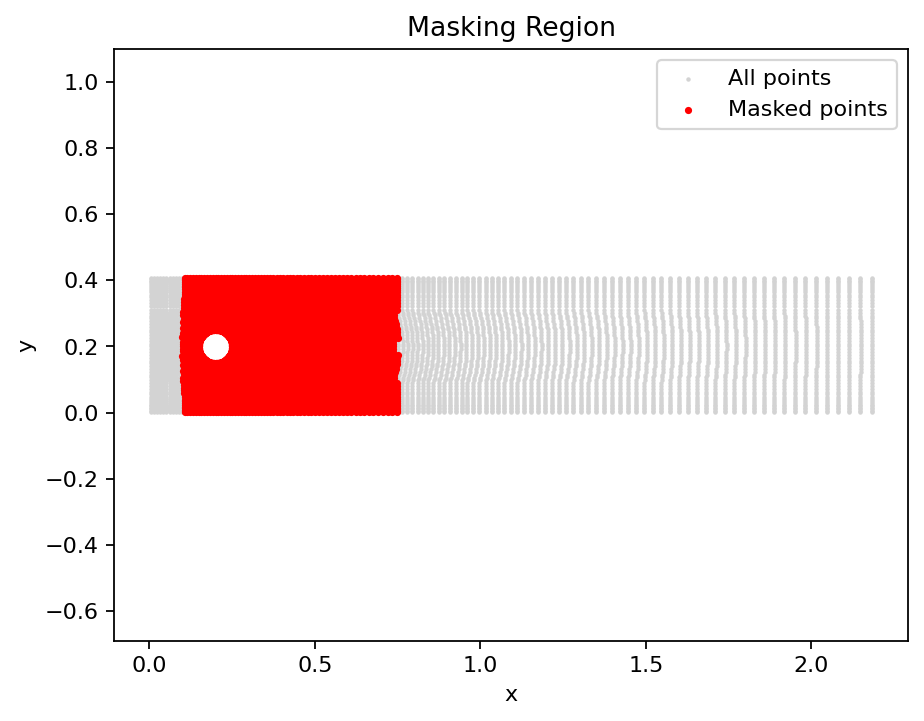

In [25]:
# Masking points in a 2D cylinder dataset using a box region

vertices = loader.vertices[:, :2]  # just x, y
mask = mask_box(vertices, lower=[0.1, -1], upper=[0.75, 1])

plt.scatter(vertices[:, 0], vertices[:, 1], s=1, c='lightgray', label='All points')
plt.scatter(vertices[mask][:, 0], vertices[mask][:, 1], s=5, c='red', label='Masked points')
plt.xlabel('x'); plt.ylabel('y')
plt.legend(); plt.title('Masking Region')
plt.axis('equal'); plt.show()


In [26]:
# Assemble velocity data matrix (e.g., x-component)

data_matrix = pt.zeros((mask.sum().item(), len(window_times)), dtype=pt.float64)
for i, time in enumerate(window_times):
    velocity_snapshot = loader.load_snapshot("U", time)  # "U" is velocity field
    data_matrix[:, i] = pt.masked_select(velocity_snapshot[:, 0], mask)  # x-component



In [27]:
# Build The DMD Operator

print("Data shape:", data_matrix.shape)
print("NaNs detected:", pt.isnan(data_matrix).any().item())
print("Infs detected:", pt.isinf(data_matrix).any().item())

# Time step
dt = float(times[1]) - float(times[0])

# Run DMD
dmd = DMD(data_matrix, dt=dt, rank=30)
print(dmd)




Data shape: torch.Size([5746, 8001])
NaNs detected: False
Infs detected: False
SVD:
SVD of a 5746x8000 data matrix
Selected/optimal rank: 30/1789
data type: torch.float64 (8b)
truncated SVD size: 3.1464Mb
LSQ:
False
Overall DMD size: 5.7909Mb
DFT frequencies (sampling, max., res.):
500.0000Hz, 250.0000Hz, 0.0625Hz



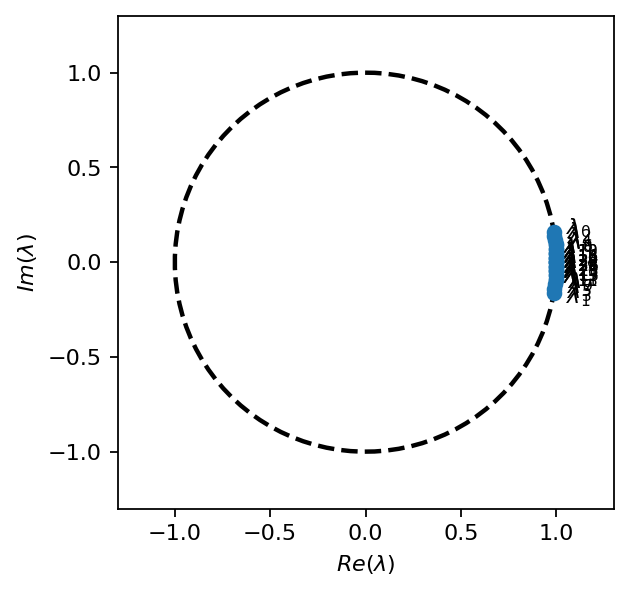

In [28]:
# Eigenvalue Analysis

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
t = pt.linspace(0, 2 * np.pi, 100)
ax.plot(pt.cos(t), pt.sin(t), ls="--", color="k", lw=2)
ax.scatter(dmd.eigvals.real, dmd.eigvals.imag, zorder=7)
ax.set_xlim(-1.3, 1.3)
ax.set_ylim(-1.3, 1.3)
ax.set_xlabel(r"$Re(\lambda)$")
ax.set_ylabel(r"$Im(\lambda)$")
for i, val in enumerate(dmd.eigvals):
    index = "{" + f"{i}" + "}"
    ax.annotate(r"$\lambda_{:s}$".format(index), (val.real*1.13, val.imag*1.13), ha='center', va="center")
plt.show()



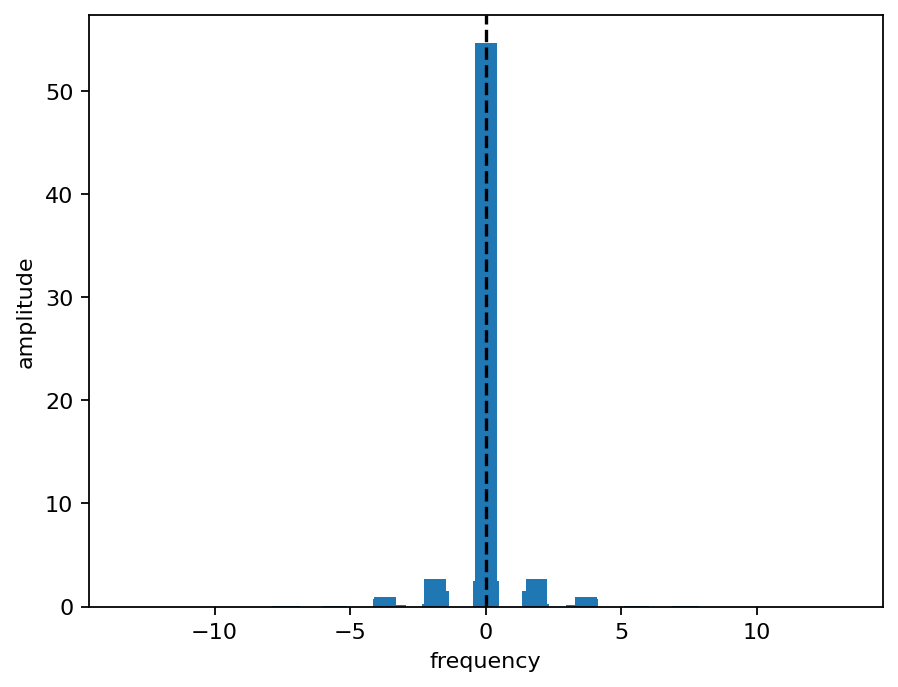

In [29]:
# Spectral Analysis 

fig, ax = plt.subplots()
amplitude = dmd.amplitude.real.abs()
_, ind = pt.topk(amplitude, 11)
ax.bar(dmd.frequency, amplitude)
for i, (a, f) in enumerate(zip(amplitude, dmd.frequency)):
    if i in ind[1:]:
        text = r"$f_{:s} = {:2.2f} Hz$".format("{"+f"{i}"+"}", f)
        ax.annotate(text, (f, a+80), ha="center", fontsize=8, rotation=90)
ax.axvline(0.0, ls="--", c="k")
ax.set_xlabel("frequency")
ax.set_ylabel("amplitude")
plt.show()

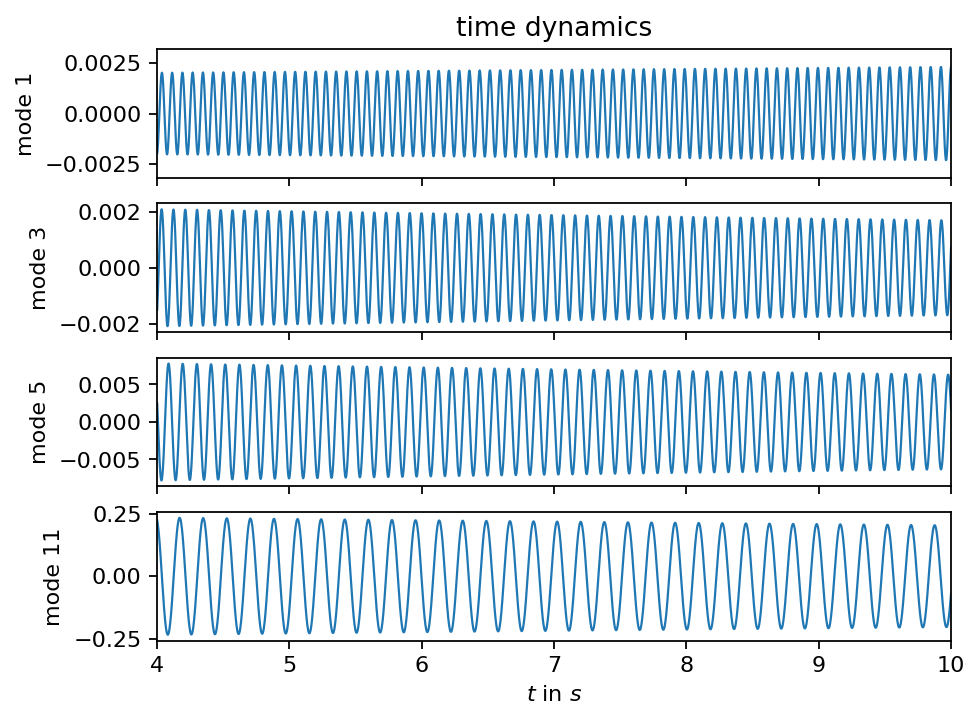

In [30]:
# Time dynamics of the selected modes

fig, axarr = plt.subplots(4, 1, sharex=True)

times_num = [float(t) for t in window_times]
modes = [1, 3, 5, 11]
for i, m in enumerate(modes):
    axarr[i].plot(times_num, dmd.dynamics[m].real, lw=1)
    axarr[i].set_ylabel(f"mode {m}")
axarr[-1].set_xlabel(r"$t$ in $s$")
axarr[-1].set_xlim(4.0, 10.0)
axarr[0].set_title("time dynamics")
plt.show()

In [31]:
# Sort DMD mode indices by descending amplitude

sorted_indices = pt.argsort(dmd.amplitude.abs(), descending=True)

# Create sorted versions of the attributes
sorted_modes = dmd.modes[:, sorted_indices]
sorted_frequency = dmd.frequency[sorted_indices]
sorted_amplitude = dmd.amplitude[sorted_indices]
sorted_eigvals = dmd.eigvals[sorted_indices]
sorted_dynamics = dmd.dynamics[sorted_indices]


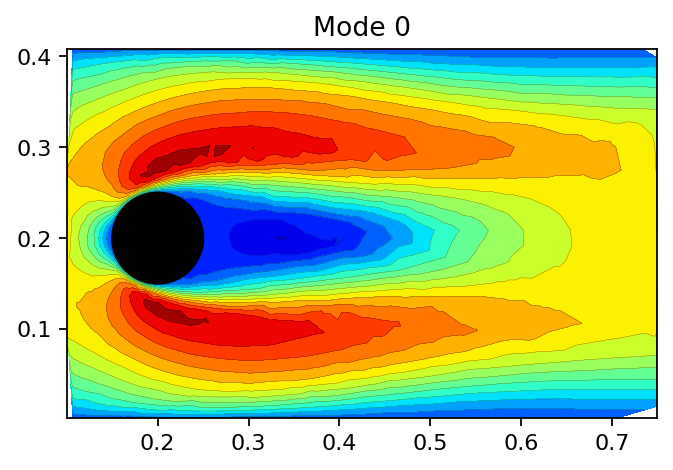

In [32]:
# Visualize the first mode

x = pt.masked_select(vertices[:, 0], mask)
y = pt.masked_select(vertices[:, 1], mask)

def add_mode(ax, mode, title, every=4):
    ax.tricontourf(x[::every], y[::every], mode[::every], levels=15, cmap="jet")
    ax.tricontour(x[::every], y[::every], mode[::every], levels=15, linewidths=0.1, colors='k')
    ax.add_patch(plt.Circle((0.2, 0.2), 0.05, color='k'))
    ax.set_aspect("equal", 'box')
    ax.set_title(title)

fig, ax = plt.subplots(figsize=(5, 3))
add_mode(ax, sorted_modes[:, 0].real, "Mode 0")
plt.show()

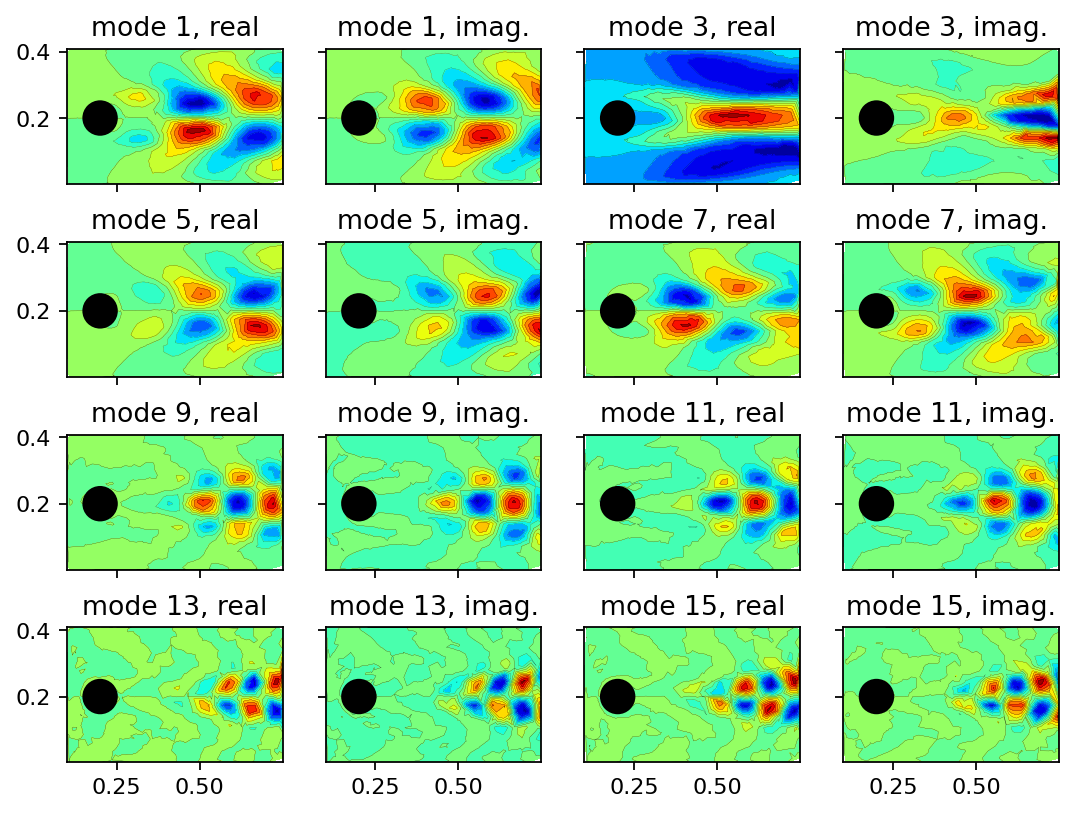

In [33]:
fig, axarr = plt.subplots(4, 4, figsize=(8, 6), sharex=True, sharey=True)
count = 1
for row in range(4):
    add_mode(axarr[row, 0], sorted_modes[:, count].real, f"mode {count}, real")
    add_mode(axarr[row, 1], sorted_modes[:, count].imag, f"mode {count}, imag.")
    count += 2
    add_mode(axarr[row, 2], sorted_modes[:, count].real, f"mode {count}, real")
    add_mode(axarr[row, 3], sorted_modes[:, count].imag, f"mode {count}, imag.")
    count += 2
plt.show()

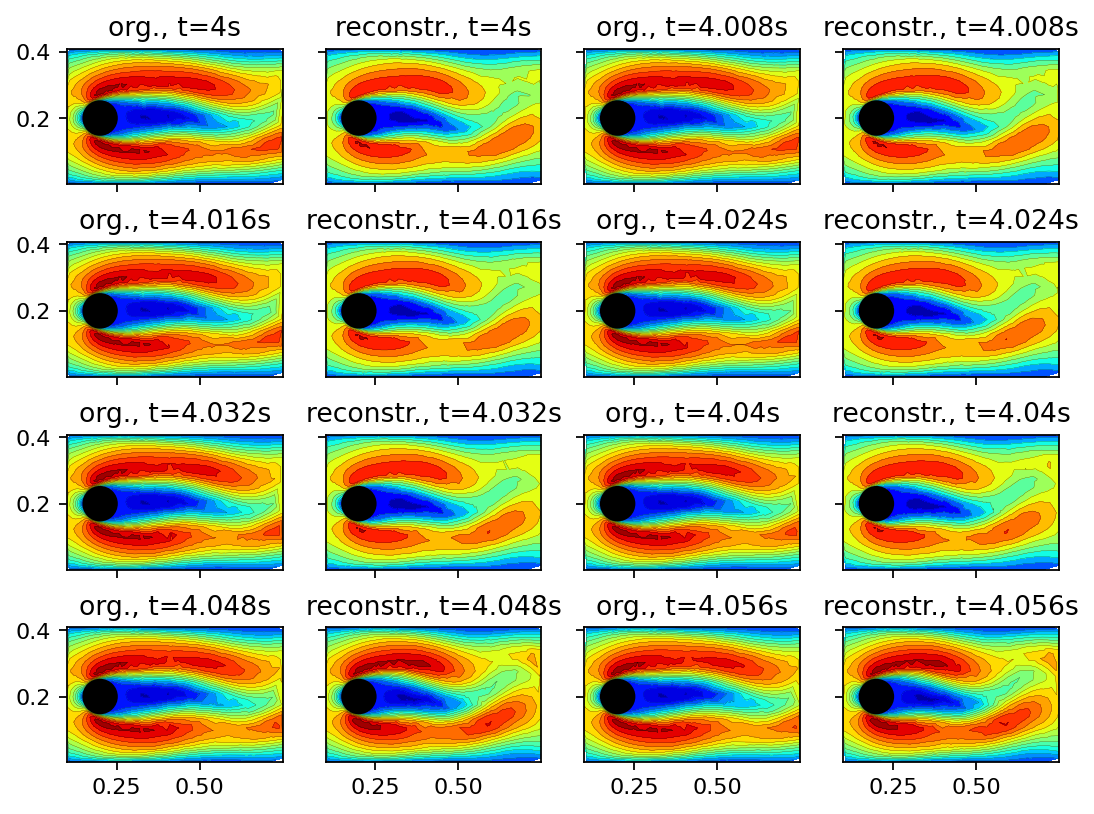

In [34]:
# Visualize DMD Reconstruction vs Original

reconstruction = dmd.reconstruction

fig, axarr = plt.subplots(4, 4, figsize=(8, 6), sharex=True, sharey=True)
count = 0
for row in range(4):
    add_mode(axarr[row, 0], data_matrix[:, count], f"org., t={window_times[count]}s")
    add_mode(axarr[row, 1], reconstruction[:, count], f"reconstr., t={window_times[count]}s")
    count += 4
    add_mode(axarr[row, 2], data_matrix[:, count], f"org., t={window_times[count]}s")
    add_mode(axarr[row, 3], reconstruction[:, count], f"reconstr., t={window_times[count]}s")
    count += 4
plt.show()

## Mean Squared Error and Similarity Index

In [35]:
# Evaluate Mean Squared Error and Similarity Index

import numpy as np

def compute_mse(original, reconstruction):
    return np.mean((original - reconstruction)**2)

In [36]:
from skimage.metrics import structural_similarity as ssim

def compute_ssim(original, reconstruction):
    score, _ = ssim(original, reconstruction, data_range=original.max() - original.min(), full=True)
    return score

In [37]:
import matplotlib.pyplot as plt

def plot_error_field(original, reconstruction, x, y, title="Error Field"):
    error = original - reconstruction
    plt.tricontourf(x, y, error, levels=30, cmap="coolwarm")
    plt.title(title)
    plt.colorbar(label="Error")
    plt.axis('equal')
    plt.show()

Snapshot 0: MSE = 0.0128, SSIM = 0.8919


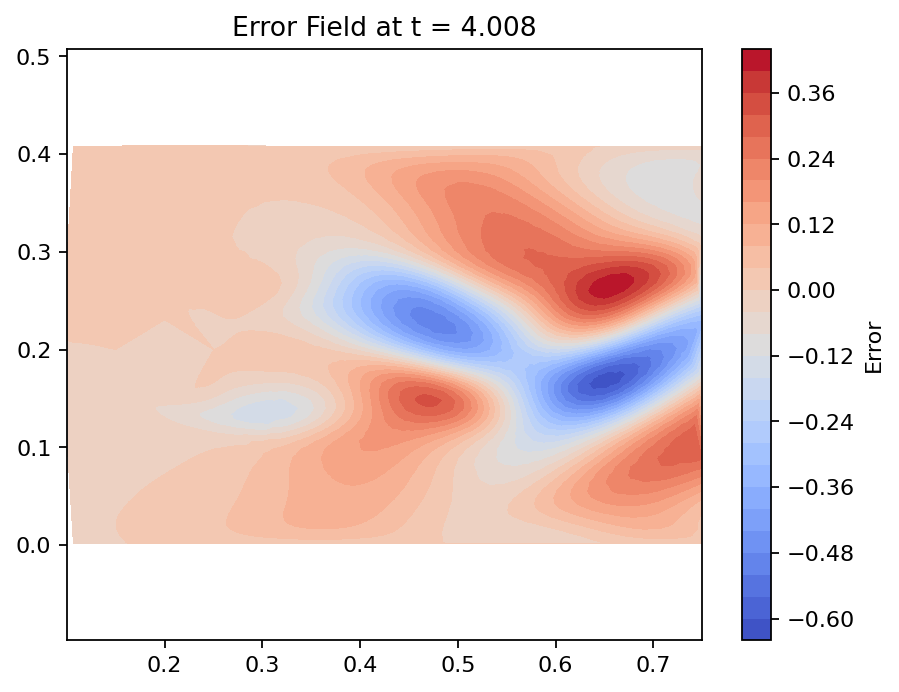

Snapshot 1: MSE = 0.0158, SSIM = 0.8717


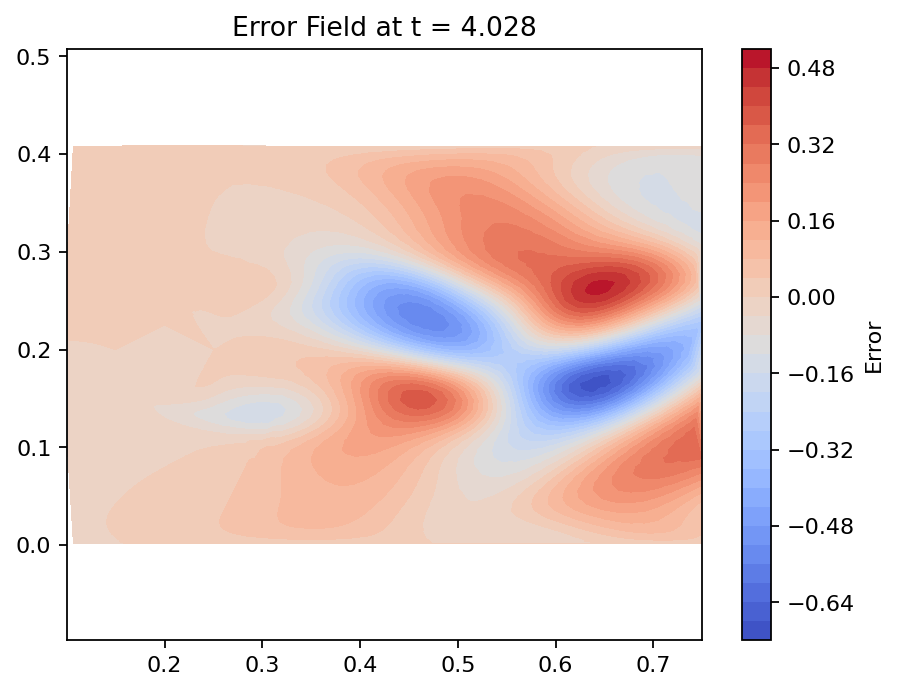

Snapshot 2: MSE = 0.0181, SSIM = 0.8570


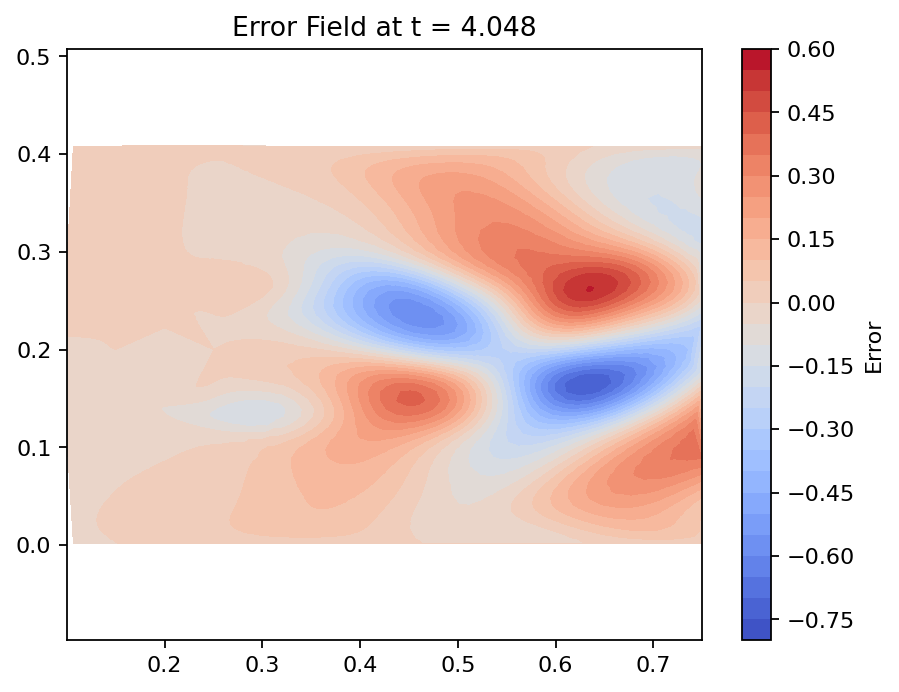

Snapshot 3: MSE = 0.0193, SSIM = 0.8489


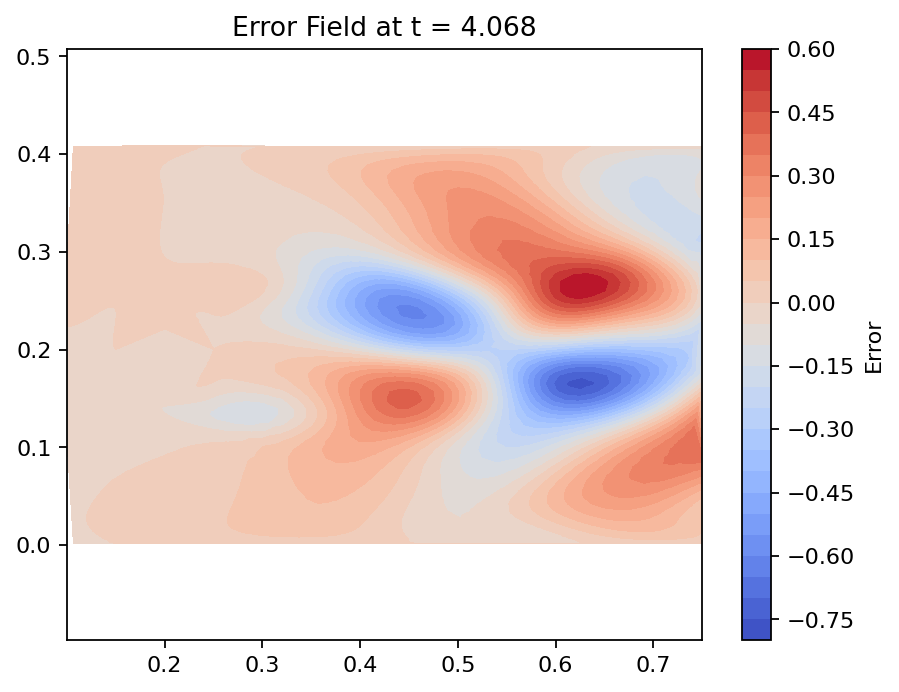

Snapshot 4: MSE = 0.0191, SSIM = 0.8475


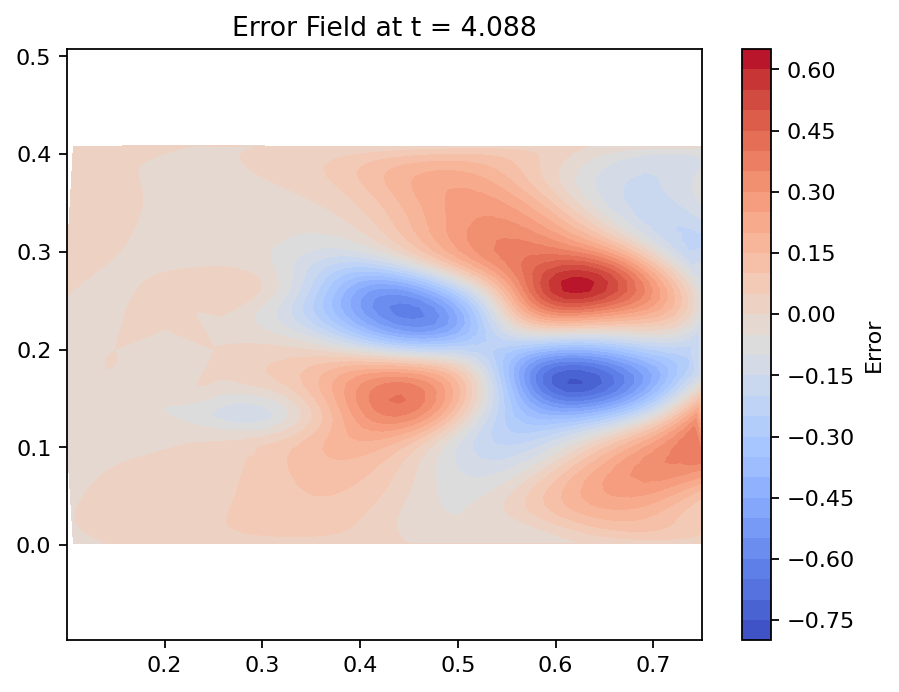

In [38]:
for i in range(5):  # or more, depending on data
    org = data_matrix[:, 4 + 10*i].numpy()
    recons = reconstruction[:, 4 + 10*i].numpy()

    
    mse = compute_mse(org, recons)
    ssim_score = compute_ssim(org, recons)

    print(f"Snapshot {i}: MSE = {mse:.4f}, SSIM = {ssim_score:.4f}")
    plot_error_field(org, recons, x, y, title=f"Error Field at t = {window_times[4 + 10*i]}")